In [1]:
# Import PyTorch Data Loader Library
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.models.segmentation import fcn_resnet50, fcn_resnet101
from torchvision import transforms

# Other Library Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics import Dice
import resource
from monai.losses import DiceLoss as MonaiDiceLoss
from monai.networks.nets import UNet
from sklearn.model_selection import train_test_split
import SimpleITK as sitk

# Custom Imports
from DRAC_Dataloading import DRAC_Loader
from DRAC_Models import ResNetBinary
from DRAC_Training import train_model
from DRAC_Testing import test_model
from DRAC_Criterion import DiceLoss
from models_unetpp import UNetPlusPlus

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA RTX A5000


In [3]:
batch_size = 1

In [4]:
# Load in the custom models
name = os.listdir("./models/")

# Print out items with structure "#. model_name"
for i in range(len(name)):
    print(f"{i}. {name[i]}")

0. fcn_resnet50_3_250_DiceLoss
1. fcn_resnet50_2_100_CrossEntropyLoss
2. UNet-Monai_8_5_MonaiDice
3. fcn_resnet50_3_250_DiceLoss_1
4. fcn_resnet50_2_50_CrossEntropyLoss
5. UNet-Monai_16_200_MonaiDice


In [5]:
file = "./models/" + name[5] + "/"
models = os.listdir(file)
models = [file + model for model in models]

# If any item in the list is a directory, remove it
models = [model for model in models if not os.path.isdir(model)]

# Reorder the list so that the .pth files are in the order Intraretinal.pth, Neovascularization.pth, Nonperfusion.pth

models

['./models/UNet-Monai_16_200_MonaiDice/model_Neovascularization.pt',
 './models/UNet-Monai_16_200_MonaiDice/model_Nonperfusion.pt',
 './models/UNet-Monai_16_200_MonaiDice/model_Intraretinal.pt']

In [6]:
# Within file create folder called "Predictions"
if not os.path.exists(file + "Predictions"):
    os.makedirs(file + "Predictions")

# Set another location
predictions = file + "Predictions/"

In [7]:
# Use os to list all items in following directory
directory = "./data/Segmentation/Original/test/"
items = os.listdir(directory)

# Item Locations
item_locations = [directory + item for item in items]

item_locations[:4]

['./data/Segmentation/Original/test/1250.png',
 './data/Segmentation/Original/test/1281.png',
 './data/Segmentation/Original/test/728.png',
 './data/Segmentation/Original/test/1172.png']

In [8]:
transforms = transforms.Compose([
    transforms.ToTensor()
])

In [9]:
test_dataset = DRAC_Loader(data = item_locations, data_names = items, transform = transforms)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [10]:
count = 0

for model1 in models:
    # Load in the model 
    model = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
    ).to(device)
    model.load_state_dict(torch.load(model1))
    model.eval()
    
    # Test the model, run if statements...
    if "Intraretinal" in model1:
        loader = test_dataloader
        loader_name = "Intraretinal"
        nii_file = "1.nii.gz"
    elif "Neovascularization" in model1:
        loader = test_dataloader
        loader_name = "Neovascularization"
        nii_file = "3.nii.gz"
    elif "Nonperfusion" in model1:
        loader = test_dataloader
        loader_name = "Nonperfusion"
        nii_file = "2.nii.gz"
    else:
        print("Error")
        break
    
    # Create an empty array to store the predicted masks
    predicted_masks = np.zeros((len(loader), 1024, 1024))
    
    for i, (inputs, name) in enumerate(loader):        
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        
        # Store the predicted mask in the array
        predicted_masks[i] = preds[0]
    print(predicted_masks.shape)    
    predicted_masks_sitk = sitk.GetImageFromArray(predicted_masks)
    sitk.WriteImage(predicted_masks_sitk, f"{predictions}{nii_file}")
    
    saveimages = False
    if saveimages:
        for inputs, name in loader:
            # Permute
            inputs = inputs.permute(0, 3, 1, 2)
            
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs['out'], 1)
            preds = preds.cpu().numpy()
            
            if not os.path.exists(f"{predictions}{loader_name}"):
                os.makedirs(f"{predictions}{loader_name}")
            
            for i in range(len(preds)):
                # Set the name of the file
                name = f"{predictions}{loader_name}/{name[0]}.png"
                
                plt.imsave(f"{name}", preds[i], cmap = 'gray')
                count += 1

(65, 1024, 1024)
(65, 1024, 1024)
(65, 1024, 1024)


In [17]:
# Load "./models/fcn_resnet50_2_50_CrossEntropyLoss/Predictions/1.nii.gz"
image = sitk.ReadImage("./models/fcn_resnet50_3_250_DiceLoss/Predictions/1.nii.gz")

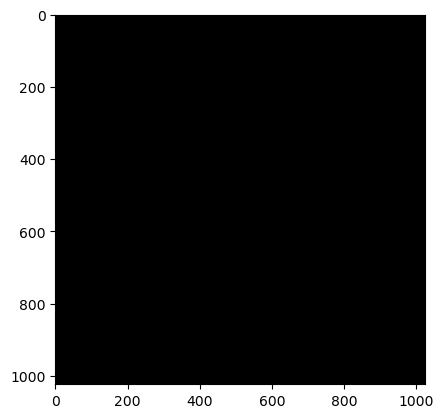

In [21]:
# plot image
plt.imshow(sitk.GetArrayFromImage(image)[50], cmap = "gray")

In [12]:
# Get the image dimensions
size = image.GetSize()
print("Image size:", size)

# Get the voxel spacing
spacing = image.GetSpacing()
print("Voxel spacing:", spacing)

# Get the image origin
origin = image.GetOrigin()
print("Image origin:", origin)

# Access the image data as a numpy array
image_array = sitk.GetArrayFromImage(image)
print("Image array shape:", image_array.shape)

Image size: (1024, 1024, 65)
Voxel spacing: (1.0, 1.0, 1.0)
Image origin: (0.0, 0.0, 0.0)
Image array shape: (65, 1024, 1024)
